In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec
from matplotlib import animation
from IPython.display import HTML

sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rc('axes',labelsize=10) 
loc = 'sector001_camera1_ccd2'
ddir = '/Users/Oliver/PhD/TASOC/TESS_data/'+loc+'.hdf5'
title = 'TESS '+loc.replace('_',' ')
title

'TESS sector001 camera1 ccd2'

In [2]:
import h5py
f = h5py.File(ddir, 'r', libver='latest')

In [3]:
indices = np.array(list(f['backgrounds']))[:200:10]

Important note:
I am only checking the functionality as it appears in the `photometry` `backgrounds.py` code, and not worrying about smoothing in time.

## Using our own changed background

### Resolution isn't going to solve this issue using the SExtractor method

## Using the TASOC data

In [80]:
globmin = np.array([np.nanmin(np.array(f['images'][idx])) for idx in indices]).min()
sumimage = np.array(f['sumimage'])
def nanmask(diffim):
    from statsmodels import robust
    return (diffim>(np.median(diffim)+np.std(diffim)*0.5))

In [81]:
def get_bkg(idx):
    return np.log10(np.array(f['backgrounds'][idx]))
def get_image(idx):
    return np.log10(np.array(f['images'][idx]+np.array(f['backgrounds'][idx])))
def get_corr(idx):
    im = np.array(f['images'][idx])
    diffim = np.abs(im - sumimage)
    im[nanmask(diffim)] = np.nan
    immin = np.nanmin(im)
    if immin <= 0:
        return np.log10(im + np.abs(globmin))
    else:
        return np.log10(im)

In [82]:
fig, ax = plt.subplots(1, 2, figsize=(18,6))
fig.suptitle(title,fontsize=20)

gs = gridspec.GridSpec(1, 3, figure=fig,wspace=0, hspace=0)
ax1 = plt.subplot(gs[:, :1])
ax2 = plt.subplot(gs[:, 1:2])
ax0 = plt.subplot(gs[:, 2:])


im0 = ax0.imshow(get_corr('0000'), animated=True, origin='lower',
                vmin=np.nanmin(get_bkg('0000')), vmax=np.nanmax(get_bkg('0000')))
im = ax1.imshow(get_image('0000'), animated=True, origin='lower',
                vmin=np.nanmin(get_bkg('0000')), vmax=np.nanmax(get_bkg('0000')))
im2 = ax2.imshow(get_bkg('0000'), animated=True, origin='lower', 
                 vmin=np.nanmin(get_bkg('0000')), vmax=np.nanmax(get_bkg('0000')))

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax0)
cax2 = divider.append_axes("right", size="2%", pad=0.05)
fig.colorbar(im0, cax=cax2,label=r'$\log_{10}(Flux)$')
                                   
ax0.set_title('Background removed',fontsize=15)    
ax1.set_title('Raw image',fontsize=15)
ax2.set_title('Background estimate',fontsize=15)
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax0.set_yticklabels([])
ax0.set_xticklabels([])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

def updatefig(idx):
    im0.set_array(get_corr(idx))
    im.set_array(get_image(idx))
    im2.set_array(get_bkg(idx))
    return im, im2,             
    
ani = animation.FuncAnimation(fig, updatefig, frames=indices,
                             blit=True, repeat=True, interval = 400)
plt.close(fig)
HTML(ani.to_html5_video())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


In [83]:
ani.save(loc+'.gif', dpi=1080, writer='pillow')

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.


TODO: Try with dbscan
TODO: Redo this but with KDE + M.A.D.

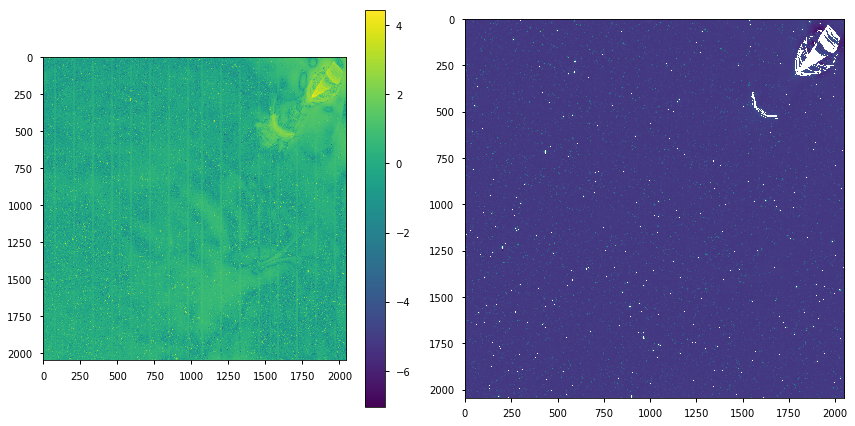

In [75]:
diffim = np.abs(10**get_corr('0000') - sumimage)
def nanmask(diffim):
    from statsmodels import robust
    return (diffim>(np.median(diffim)+np.std(diffim)))

fig, ax = plt.subplots(1,2,figsize=(12,6))
sumimage = np.array(f['sumimage']+np.abs(globmin))
diffim = np.abs(10**get_corr('0000') - sumimage)
im = ax[0].imshow(np.log10(diffim))
fig.colorbar(im, ax=ax[0])

im = get_corr('0000')
im[nanmask(diffim)] = np.nan
ax[1].imshow(im)
fig.tight_layout()
plt.show()

## Pros: Simple
## Cons: Makes more of a mess, doesn't get negative spaces

In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=0.3, min_samples=10).fit(diffim)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

### A fun test as an aside

In [8]:
from tqdm import tqdm
flux = np.zeros(len(list(f['backgrounds'])))
for idx, i in tqdm(enumerate(list(f['backgrounds']))):
    flux[idx] = np.sum(f['backgrounds'][i])

1282it [02:09,  9.93it/s]


In [9]:
time = np.array(f['time'])

In [10]:
from lightkurve import LightCurve
from astropy import units as u
lc = LightCurve(time, flux)
pg = lc.normalize().flatten().to_periodogram()

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


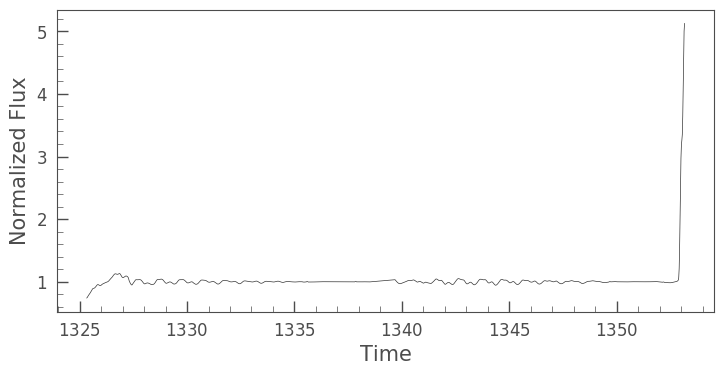

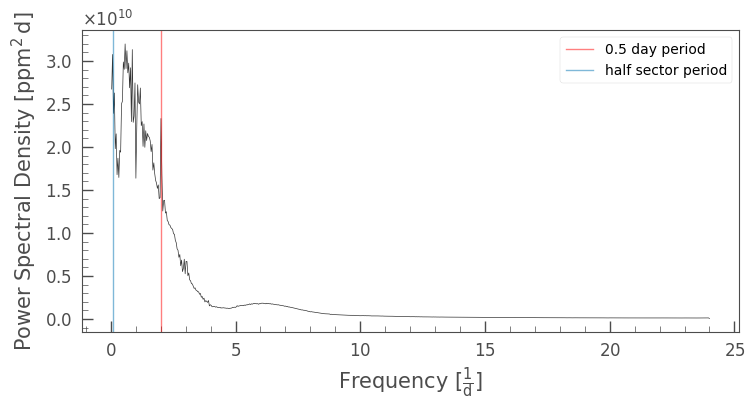

In [11]:
lc.normalize().flatten().plot()
plt.show()

ax = pg.plot()
ax.axvline(1/0.5, linewidth=1, alpha=.5, c='r', label='0.5 day period')
ax.axvline(1/(27/2), linewidth=1, alpha=.5, label='half sector period')
ax.legend()
plt.show()